# Customer Segmentation in Python
## Segmentation using K-Means clustering algorithm


### Plan Of Attack

- Gather the data
- Pre-process the data
- Explore the data
- Cluster the data
- Interpret the result

### The Analysis

#### Gathering Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df_lst = []

for sheet in ['Year 2009-2010','Year 2010-2011']:
    df = pd.read_excel('RetailPulseAssignmentData.xlsx', sheet_name=sheet)
    df_lst.append(df)
df = pd.concat(df_lst)
print(df.shape)
df.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Clean & Sample the data

In [3]:
df = df[df['Customer ID'].notna()]
df_fix = df.sample(20000, random_state = 42)
df_fix = df_fix.convert_dtypes()
print(df_fix.shape)
df_fix.head()

(20000, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
198038,554000,23281,FOLDING BUTTERFLY MIRROR RED,12,2011-05-20 11:53:00,0.83,14794,United Kingdom
457037,575729,22406,MONEY BOX KINGS CHOICE DESIGN,12,2011-11-10 19:49:00,1.25,17932,United Kingdom
236404,512286,22435,SET OF 9 HEART SHAPED BALLOONS,10,2010-06-14 14:27:00,1.25,15967,United Kingdom
435239,530957,22800,ANTIQUE TALL SWIRLGLASS TRINKET POT,8,2010-11-04 18:53:00,3.75,17340,United Kingdom
214547,555586,84212,"ASSORTED FLOWER COLOUR ""LEIS""",72,2011-06-06 09:12:00,0.65,14232,United Kingdom


### Data Preprocessing
#### Create RFM Table

The RFM refers to Recency , Frequency & Monetary Value.

Recency - The number of days passed since the last invoice date for the customer<br>
Frequency - The total number of invoices exist for the customer<br>
Monetary Value - The total money the customer spent

In [4]:
# Convert to show date only
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["Price"]

snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'Invoice': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

customers.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
12347,40,4,58.4
12348,359,1,40.8
12349,19,3,57.45
12351,376,3,37.8
12352,73,2,45.3


#### Manage Skewness

C:\Users\Ashwin Gunasekaran\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ashwin Gunasekaran\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ashwin Gunasekaran\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

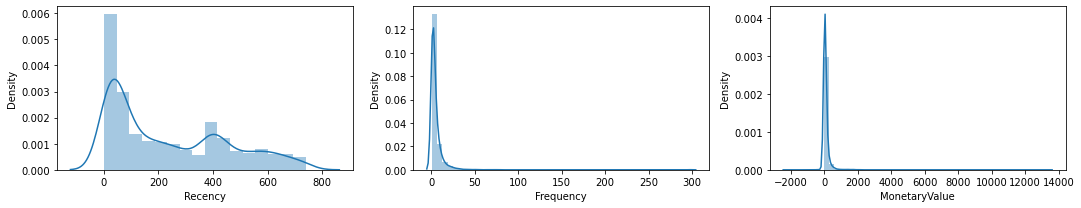

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [6]:
customers.min()

Recency             1.00
Frequency           1.00
MonetaryValue   -2225.17
dtype: float64

In [7]:
for col_name in customers:
    print(col_name)
    
    if col_name in ['Recency','Frequency']:
        sqrt_sr = np.sqrt(customers[col_name]) 
        log_sr = np.log(customers[col_name]) 
        boxcox_sr = pd.Series(stats.boxcox(customers[col_name])[0], name='boxcox')

        print('Skewness after SQRT Transformation = %.2f' %sqrt_sr.skew())
        print('Skewness after LOG Transformation = %.2f' %log_sr.skew())
        print('Skewness after BOXCOX Transformation = %.2f\n' %boxcox_sr.skew())

    else:
        cbrt_sr = np.cbrt(customers[col_name])
        print('Skewness after CUBE ROOT Transformation = %.2f\n' %cbrt_sr.skew())

Recency
Skewness after SQRT Transformation = 0.15
Skewness after LOG Transformation = -0.75
Skewness after BOXCOX Transformation = -0.17

Frequency
Skewness after SQRT Transformation = 3.37
Skewness after LOG Transformation = 0.69
Skewness after BOXCOX Transformation = 0.11

MonetaryValue
Skewness after CUBE ROOT Transformation = 0.97



SQRT Transformation is the most suitable transformation for Recency<br>
Box cox is the most suitable transformation for Frequency<br>
Cube root is the most suitable transformation for Monetary Value

In [8]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix["Recency"] = np.sqrt(customers['Recency']).values
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.head()

,Recency,Frequency,MonetaryValue
0,6.324555,1.109701,3.879755
1,18.947295,0.000000,3.442601
2,4.358899,0.919637,3.858602
3,19.390719,0.919637,3.356067
4,8.544004,0.618777,3.56478


#### Centering and Scaling Variables

We do this so that all the features have same mean and variance

In [9]:
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized.head()

[ 0. -0. -0.]
[1. 1. 1.]


,Recency,Frequency,MonetaryValue,ID
0,-0.928825,0.486613,0.137152,12347
1,0.742523,-1.261232,-0.077437,12348
2,-1.189093,0.187251,0.126768,12349
3,0.801236,0.187251,-0.119915,12351
4,-0.634953,-0.286621,-0.017462,12352


### Modelling
#### Choose k-value

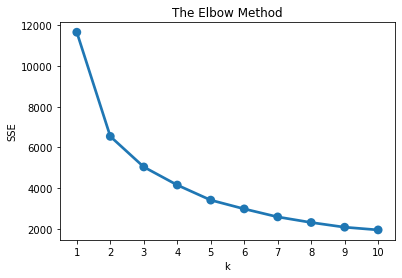

In [10]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Choosing k value 3 as the best value for k

In [11]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_

array([2, 1, 0, ..., 2, 1, 0])

### Cluster Analysis

In [12]:
customers["Cluster"] = model.labels_
gdf = customers.groupby('Cluster').agg(RecencyMean=('Recency','mean'), FrequencyMean=('Frequency','mean'), 
                                      MonetaryValueMean=('MonetaryValue','mean'), Count=('MonetaryValue','count'))
gdf['MonetaryValueMean'] = gdf['MonetaryValueMean'].astype('float64')
gdf.round(2)

,RecencyMean,FrequencyMean,MonetaryValueMean,Count
Cluster,,,,
0,75.00,2.36,24.82,1081
1,458.28,1.91,31.06,1571
2,90.60,11.73,252.89,1232


### Snake Plots

In [13]:
df_normalized['Cluster'] = model.labels_

# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347,2,Recency,-0.928825
1,12348,1,Recency,0.742523
2,12349,0,Recency,-1.189093
3,12351,1,Recency,0.801236
4,12352,0,Recency,-0.634953


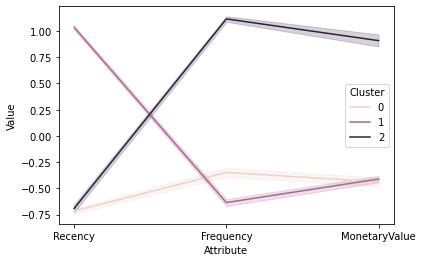

In [14]:
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)
plt.show()

Cluster 0 Insights: 
* Cluster 0 has Lower Recency, Lower Frequency and Lower Monetary Value from which we can infer it is a cluster of **new customers**

Cluster 1 Insights:
* Cluster 1 has Lower Recency, Higher Frequency and Higher Monetary Value from which we can infer it is a cluster of **loyal customers**

Cluster 2 Insights:
* Cluster 2 Higher Recency, Lower Frequency and Lower Monetary value  from which we can infer it is a cluster of **churned customers**

Hence we have successfully segmented the customers into 3 categories using KMeans Machine Learning Algorithm.